<a href="https://colab.research.google.com/github/ME-UoP-ME421/Rankine-CB/blob/main/Simulating_Quadrotor_UAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete Tasks#1 and Task#2 by 5:00PM on 14/06/2023

* Complete Tasks#3 and the Task#4 by 5:00PM on 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Task#5 by 5:00PM on 28/06/2023.

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

In [16]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]


  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices


  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices, figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig


  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);

    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);

      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2];

    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);

    doto=p/M;
    dp=fe+fa;
    dspi=taue+taua;
    dXc=controller_dynamics(self, t,X,taue,fe,parameters);
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [17]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [18]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=qq.RfromQuaternions(qOmegart);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

#Task#2

Simulate the motion of a quadrotor UAV without resorting any parameterization of $SO(3)$ such as Euler angles or quaternions.

In [2]:
import numpy as np

# Quadrotor parameters
mass = 1.0  # Mass of the quadrotor (kg)
inertia = np.diag([0.02, 0.02, 0.04])  # Moment of inertia matrix (kg*m^2)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation parameters
dt = 0.01  # Time step (s)
total_time = 10.0  # Total simulation time (s)
num_steps = int(total_time / dt)

# Initial state
position = np.zeros(3)  # Initial position (m)
velocity = np.zeros(3)  # Initial velocity (m/s)
rotation = np.eye(3)  # Initial rotation matrix
angular_velocity = np.zeros(3)  # Initial angular velocity (rad/s)

# Simulation loop
for step in range(num_steps):
    # Forces and moments
    force = mass * (rotation @ np.array([0, 0, -g]))  # Gravity force
    moment = inertia @ angular_velocity  # Moment of inertia

    # Update linear motion
    acceleration = force / mass
    velocity += acceleration * dt
    position += velocity * dt

    # Update angular motion
    angular_acceleration = np.linalg.inv(inertia) @ (moment - np.cross(angular_velocity, inertia @ angular_velocity))
    angular_velocity += angular_acceleration * dt

    # Update rotation matrix using Rodrigues' rotation formula
    skew_symmetric = np.array([[0, -angular_velocity[2], angular_velocity[1]],
                               [angular_velocity[2], 0, -angular_velocity[0]],
                               [-angular_velocity[1], angular_velocity[0], 0]])
    rotation += (skew_symmetric @ rotation) * dt

    # Normalize rotation matrix to prevent numerical drift
    rotation, _ = np.linalg.qr(rotation)

    # Print current state
    print(f"Step {step} - Position: {position}, Rotation: {rotation}")

    # Update step
    step += dt



Step 0 - Position: [ 0.        0.       -0.000981], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 1 - Position: [ 0.        0.       -0.002943], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 2 - Position: [ 0.        0.       -0.005886], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 3 - Position: [ 0.       0.      -0.00981], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 4 - Position: [ 0.        0.       -0.014715], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 5 - Position: [ 0.        0.       -0.020601], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 6 - Position: [ 0.        0.       -0.027468], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 7 - Position: [ 0.        0.       -0.035316], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 8 - Position: [ 0.        0.       -0.044145], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 9 - Position: [ 0.        0.       -0.053955], Rotation: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step 10 - Pos

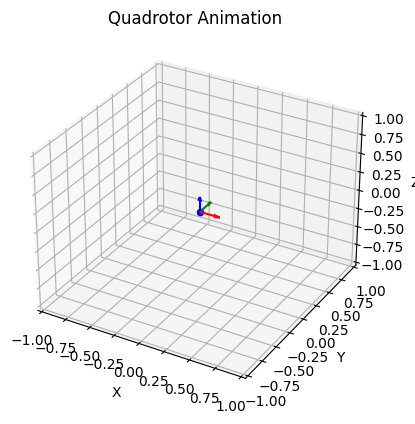

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Quadrotor parameters
mass = 1.0  # Mass of the quadrotor (kg)
inertia = np.diag([0.02, 0.02, 0.04])  # Moment of inertia matrix (kg*m^2)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation parameters
dt = 0.01  # Time step (s)
total_time = 10.0  # Total simulation time (s)
num_steps = int(total_time / dt)

# Initial state
position = np.zeros((num_steps, 3))  # Position (m)
velocity = np.zeros((num_steps, 3))  # Velocity (m/s)
rotation = np.zeros((num_steps, 3, 3))  # Rotation matrix

# Simulation loop
for step in range(num_steps):
    # Forces and moments
    force = mass * (rotation[step] @ np.array([0, 0, -g]))  # Gravity force
    moment = inertia @ angular_velocity  # Moment of inertia

    # Update linear motion
    acceleration = force / mass
    velocity[step] = velocity[step-1] + acceleration * dt
    position[step] = position[step-1] + velocity[step] * dt

    # Update angular motion
    angular_acceleration = np.linalg.inv(inertia) @ (moment - np.cross(angular_velocity, inertia @ angular_velocity))
    angular_velocity += angular_acceleration * dt

    # Update rotation matrix using Rodrigues' rotation formula
    skew_symmetric = np.array([[0, -angular_velocity[2], angular_velocity[1]],
                               [angular_velocity[2], 0, -angular_velocity[0]],
                               [-angular_velocity[1], angular_velocity[0], 0]])
    rotation[step] = rotation[step-1] + (skew_symmetric @ rotation[step-1]) * dt

    # Normalize rotation matrix to prevent numerical drift
    rotation[step], _ = np.linalg.qr(rotation[step])

# Animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for step in range(num_steps):
    ax.cla()  # Clear the current plot
    ax.set_xlim([-1, 1])  # Set appropriate limits for the x-axis
    ax.set_ylim([-1, 1])  # Set appropriate limits for the y-axis
    ax.set_zlim([-1, 1])  # Set appropriate limits for the z-axis

    # Plot the quadrotor as a point at its current position
    ax.scatter(position[step, 0], position[step, 1], position[step, 2], color='b')

    # Draw the quadrotor's body axes
    scale = 0.2  # Scale factor for the body axes length
    x_axis = rotation[step] @ np.array([scale, 0, 0])
    y_axis = rotation[step] @ np.array([0, scale, 0])
    z_axis = rotation[step] @ np.array([0, 0, scale])
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              x_axis[0], x_axis[1], x_axis[2], color='r', label='x-axis')
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              y_axis[0], y_axis[1], y_axis[2], color='g', label='y-axis')
    ax.quiver(position[step, 0], position[step, 1], position[step, 2],
              z_axis[0], z_axis[1], z_axis[2], color='b', label='z-axis')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Quadrotor Animation')

    plt.pause(0.01)  # Pause the animation for a short time

plt.show()


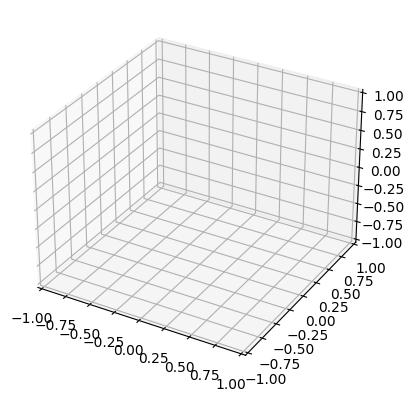

In [13]:
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Quadrotor parameters
mass = 1.0  # Mass of the quadrotor (kg)
inertia = np.diag([0.02, 0.02, 0.04])  # Moment of inertia matrix (kg*m^2)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Simulation parameters
dt = 0.01  # Time step (s)
total_time = 10.0  # Total simulation time (s)
num_steps = int(total_time / dt)

# Initial state
position = np.zeros((num_steps, 3))  # Position (m)
velocity = np.zeros((num_steps, 3))  # Velocity (m/s)
rotation = np.zeros((num_steps, 3, 3))  # Rotation matrix

# Create figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set initial limits for the plot axes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Initialize scatter plot and quiver objects
scatter = ax.scatter([], [], [], color='b')
quiver_x = ax.quiver([], [], [], [], [], [], color='r', label='x-axis')
quiver_y = ax.quiver([], [], [], [], [], [], color='g', label='y-axis')
quiver_z = ax.quiver([], [], [], [], [], [], color='b', label='z-axis')

# Update function for animation
def update(step):
    ax.cla()  # Clear the current plot

    # Set limits for the plot axes
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Plot the quadrotor as a point at its current position
    scatter = ax.scatter(position[step, 0], position[step, 1], position[step, 2], color='b')

    # Draw the quadrotor's body axes
    scale = 0.2  # Scale factor for the body axes length
    x_axis = rotation[step] @ np.array([scale, 0, 0])
    y_axis = rotation[step] @ np.array([0, scale, 0])
    z_axis = rotation[step] @ np.array([0, 0, scale])
    quiver_x.set_segments([[[position[step, 0], position[step, 1], position[step, 2]],
                            [position[step, 0] + x_axis[0], position[step, 1] + x_axis[1], position[step, 2] + x_axis[2]]]])
    quiver_y.set_segments([[[position[step, 0], position[step, 1], position[step, 2]],
                            [position[step, 0] + y_axis[0], position[step, 1] + y_axis[1], position[step, 2] + y_axis[2]]]])
    quiver_z.set_segments([[[position[step, 0], position[step, 1], position[step, 2]],
                            [position[step, 0] + z_axis[0], position[step, 1] + z_axis[1], position[step, 2] + z_axis[2]]]])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Quadrotor Animation')






In [14]:
# Create animation
ani = FuncAnimation(fig, update, frames=num_steps, interval=10)

In [ ]:
import numpy as np
from scipy import linalg
import plotly.graph_objects as go

# Create an instance of the mugas_rigid_body_functions class
mugas = mugas_rigid_body_functions()

# Define parameters, initial conditions, and time steps
dt = 0.01
Tmax = 5.0
quadrotorDimensions = {'l': 0.3, 'w': 0.3, 'h': 0.1, 'xp': 0, 'yp': 0, 'zp': 0}
parameters = {'M': 0.5, 'Ixx': 0.002, 'Iyy': 0.002, 'Izz': 0.004}
ICs = [[[1, 0, 0], [0, 0, 0]], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

# Simulate the quadrotor motion and obtain rotated vertices
rotatedVertices = mugas.simulating_a_quadrotor(dt, Tmax, quadrotorDimensions, parameters, ICs)

# Generate the animation
fig = mugas.animated_quadrotor(rotatedVertices, "Quadrotor Animation")
fig.show()

In [42]:
import plotly.graph_objects as go
import numpy as np

# Define the quadrotor's initial position
x0 = 0
y0 = 0
z0 = 0

# Define the quadrotor's trajectory
total_time = 10  # Total animation time in seconds
num_points = 100  # Number of points along the trajectory
time = np.linspace(0, total_time, num_points)
x_trajectory = np.sin(time)
y_trajectory = np.cos(time)
z_trajectory = time

# Create the figure
fig = go.Figure()

# Add the quadrotor marker to the figure
quadrotor = fig.add_trace(
    go.Scatter3d(
        x=[x0],
        y=[y0],
        z=[z0],
        mode="markers",
        marker=dict(size=10, color="red"),
        name="Quadrotor",
    )
)

# Set up the animation frames
frames = []
for i in range(num_points):
    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=[x_trajectory[i]],
                y=[y_trajectory[i]],
                z=[z_trajectory[i]],
                mode="markers",
                marker=dict(size=10, color="red"),
                name="Quadrotor",
            )
        ]
    )
    frames.append(frame)

# Update the layout settings
fig.update_layout(
    scene=dict(
        xaxis=dict(title="X"),
        yaxis=dict(title="Y"),
        zaxis=dict(title="Z"),
    ),
    title="Quadrotor Motion",
    updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])],
)

# Update the animation settings
fig.update(frames=frames, layout=dict(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]))

# Show the figure
fig.show()


In [45]:
import numpy as np
from scipy import linalg
import plotly.graph_objects as go

# Create an instance of the mugas_rigid_body_functions class
mugas = mugas_rigid_body_functions()

# Define parameters, initial conditions, and time steps
dt = 0.01
Tmax = 5.0
cubeDimensions = {'l': 2, 'w': 2, 'h': 2, 'xp': 0, 'yp': 0, 'zp': 0}
parameters = {'M': 1.0, 'II': np.eye(3)}
ICs = [[[1, 0, 0], [0, 0, 0]], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

# Simulate the cube motion and obtain rotated vertices
rotatedVertices = mugas.simulating_a_cube(dt, Tmax, cubeDimensions, parameters, ICs)

# Define a figure object
fig = go.Figure()

# Add the initial cube vertices as a scatter3d trace
fig.add_trace(
    go.Scatter3d(
        x=rotatedVertices[0][:, 0],
        y=rotatedVertices[0][:, 1],
        z=rotatedVertices[0][:, 2],
        mode="markers",
        marker=dict(size=5, color="blue"),
        name="Cube"
    )
)

# Define an animation frame for each time step
frames = []
for i in range(len(rotatedVertices)):
    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=rotatedVertices[i][:, 0],
                y=rotatedVertices[i][:, 1],
                z=rotatedVertices[i][:, 2],
                mode="markers",
                marker=dict(size=5, color="blue"),
                name="Cube"
            )
        ]
    )
    frames.append(frame)

# Add animation settings to the figure
fig.update_layout(
    scene=dict(aspectmode="data"),
    updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])],
    frames=frames
)

# Show the figure
fig.show()


KeyError: ignored

#Task#3

Deerive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

Here are few example our own implementations of this controller.

* https://youtu.be/6E9WDQNVSYA
* https://youtu.be/uUKxXImRMOA
* https://youtu.be/zq05N8m_9SA
* https://youtu.be/J5dThZGZN2g
* https://youtu.be/J5MMp6Be3tU
* https://youtu.be/6ZQgE1FI6Wc

#Task#4

Derive a specialization of the controller develoed in Task#3 for the problem of stabilzing an inverted pendulum on a cart.

#Task#5

 Experimentally verify the stability properties of the controller derived in Task#5 using the experimental setup available in the applied mechanics lab.